In [2]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GroupKFold
import csv
import statistics
from lightgbm import LGBMRegressor



after receiving data and labels, I make sure to create a model and run the model to get results

In [56]:
# create train / test split
# Features and target
# partition of the data
N_SPLITS = 6
df_one_row_per_game = pd.read_csv("df_one_row_per_game.csv")

y = df_one_row_per_game['rating']
X = df_one_row_per_game.drop(['rating', 'game_id', 'player_to_predict'], axis=1)
groups = df_one_row_per_game["player_to_predict"].values
gkf = GroupKFold(n_splits=N_SPLITS)

# run a few models on the decision
models = []
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Train model for this fold
    model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    use_label_encoder=False)
    model.fit(X_train, y_train)
    models.append(model)  # save the model


C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:16:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:16:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:16:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:16:18] WARNING: 

parsing the submission file for the result

In [54]:
# releasing all the data we want to go over
df_one_row_per_test_game = pd.read_csv("df_test_one_row_per_game.csv")

# keep only the rows we want to predict the data on
df_one_row_per_test_game_parsed = df_one_row_per_test_game[df_one_row_per_test_game["rating"].isna()]

# predicting the data
game_id_column = df_one_row_per_test_game_parsed["game_id"]
X_parsed = df_one_row_per_test_game_parsed.drop(['rating', 'game_id', 'player_to_predict'], axis=1)
rating_predictions_list = []
for model in models:
    rating_predictions_list.append(model.predict(X_parsed))
rating_predictions = [statistics.mean(k) for k in zip(*rating_predictions_list)]

rows = zip(game_id_column, rating_predictions)
with open("submission.csv", 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(["game_id", "rating"])

    # Write all the data rows
    writer.writerows(rows)


testing on the training data

In [59]:
# test the model and get its precision percentage on the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

predictions = []
for model in models:
     predictions.append(model.predict(X_test))
y_pred = [statistics.mean(k) for k in zip(*predictions)]
rmse = np.sqrt(mean_squared_error(y_test.to_numpy(), np.array(y_pred)))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)

RMSE: 38.105170624474475
R²: 0.9729741802240396


checking different models for the data

C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:15:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:15:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:15:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\King Yair\PycharmProjects\ScrabblePorject\.venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:15:25] WARNING: 

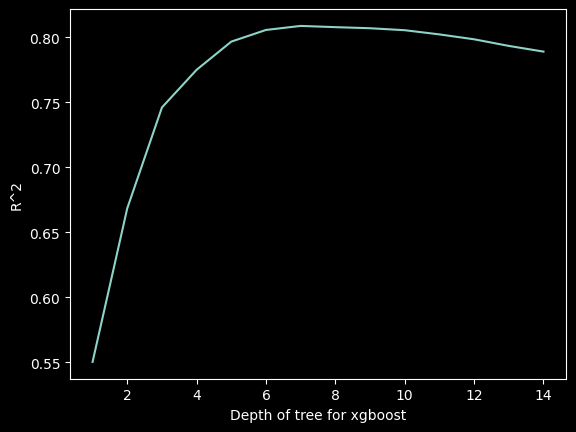

In [133]:
df_one_row_per_game = pd.read_csv("df_one_row_per_game.csv")

y = df_one_row_per_game['rating']
X = df_one_row_per_game.drop(['rating', 'game_id', 'player_to_predict'], axis=1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
max_depths = np.arange(1, 15)
list_r_squared = []
for curr_depth in max_depths:
    model = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=8,
        learning_rate=0.1,
        use_label_encoder=False)

    # model = RandomForestRegressor(n_estimators=1000, max_depth=3, random_state=42)
    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    list_r_squared.append(r2_score(y_test, y_pred))

# draw the data
plt.plot(max_depths, list_r_squared)
plt.xlabel("Depth of tree for xgboost")
plt.ylabel("R^2")
plt.show()

analyzing feature importance


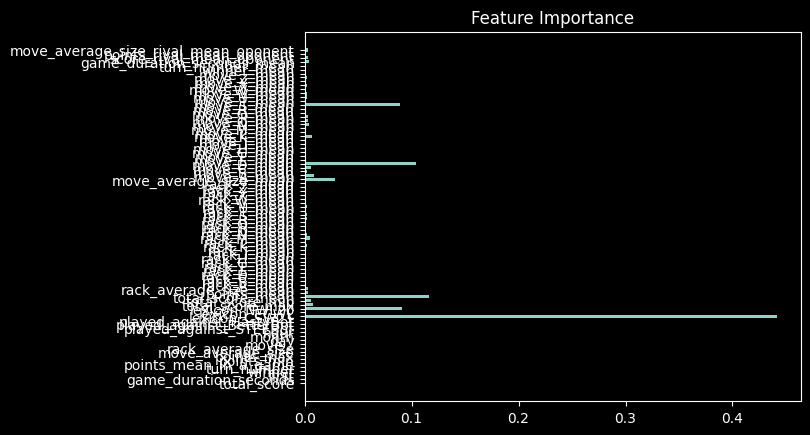

lexicon_CSW21             0.441607
total_score_mean          0.116378
move_D_mean               0.104518
lexicon_NWL20             0.091473
move_S_mean               0.089058
move_average_size_mean    0.028283
move_A_mean               0.008681
total_score_max           0.008156
move_K_mean               0.007247
move_C_mean               0.006330
dtype: float32


In [37]:
# check feature importance
# print("importance of different features:")
# for feature, importance in zip(X.columns, model.feature_importances_):
#     print(f"{feature}: {importance}")
# selected_features = X.columns[selector.support_]
# rankings = selector.ranking_[selector.support_]
# plt.barh(selected_features, rankings)
# plt.xlabel("Feature ranking (1 = selected)")

plt.barh(X.columns, model.feature_importances_)
plt.title("Feature Importance")
plt.show()

importances = model.feature_importances_
feature_names = X.columns

fi = pd.Series(importances, index=feature_names)
top5 = fi.sort_values(ascending=False).head(10)

print(top5)